(ifu-results-doc)=
# Reviewing IFS results

In this tutorial, we are going to explore some tools to check the measurements from the [SHOC579 MANGA measurements](../2_guides/7_ifu_line_fitting.ipynb).

Let’s start by loading the input and output data:

In [2]:
import numpy as np
import lime
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt

# State the data location
cfg_file = '../0_resources/ifu_manga.toml'
cube_address = '../0_resources/spectra/manga-8626-12704-LOGCUBE.fits.gz'
bands_file_0 = '../0_resources/bands/SHOC579_MASK0_bands.txt'
spatial_mask_file = '../0_resources/results/SHOC579_mask_SN_line.fits'
output_lines_log_file = '../0_resources/SHOC579_log.fits'

# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Load the Cube
z_obj = obs_cfg['SHOC579']['redshift']
shoc579 = lime.Cube.from_file(cube_address, instrument='manga', redshift=z_obj)

a string value was expected. [astropy.wcs.wcs]


If we include the ``lines_file`` argument in the [$\tt{lime.Cube.check.cube}$](../3_explanations/0_measurements.rst) function you can review the spaxel spectrum with the fitted profiles:

/home/vital/anaconda3/envs/lime2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


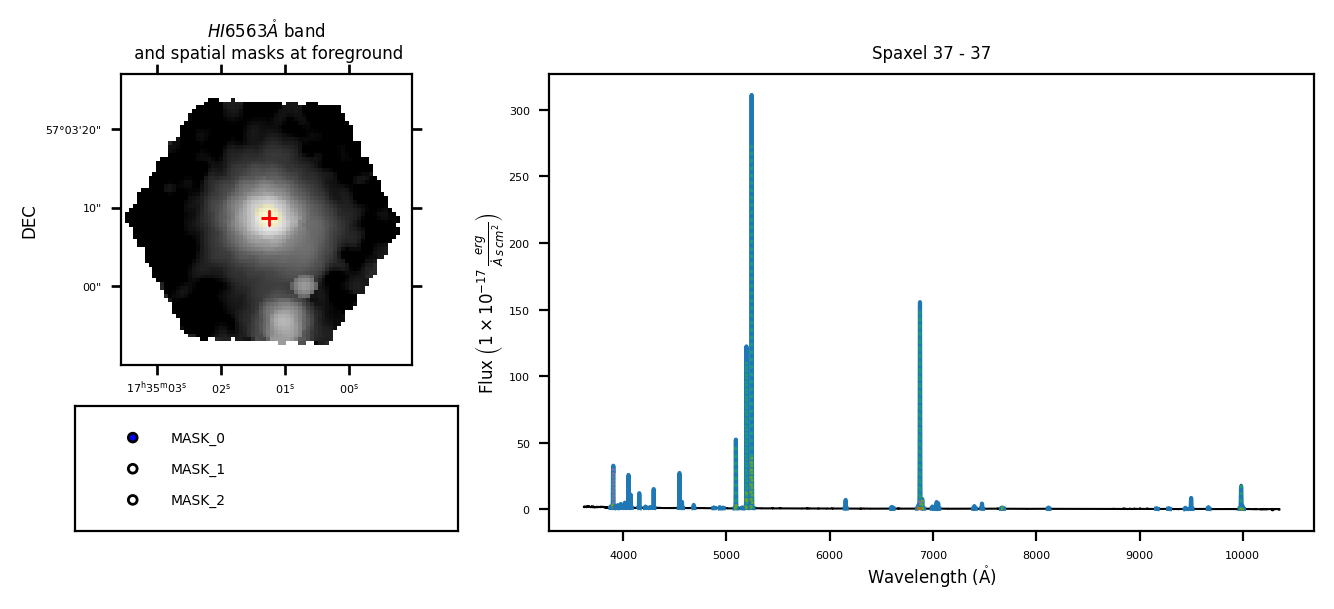

In [3]:
shoc579.check.cube('H1_6563A', fname=output_lines_log_file, masks_file=spatial_mask_file)

Or you can load the measurements from individual spaxels:

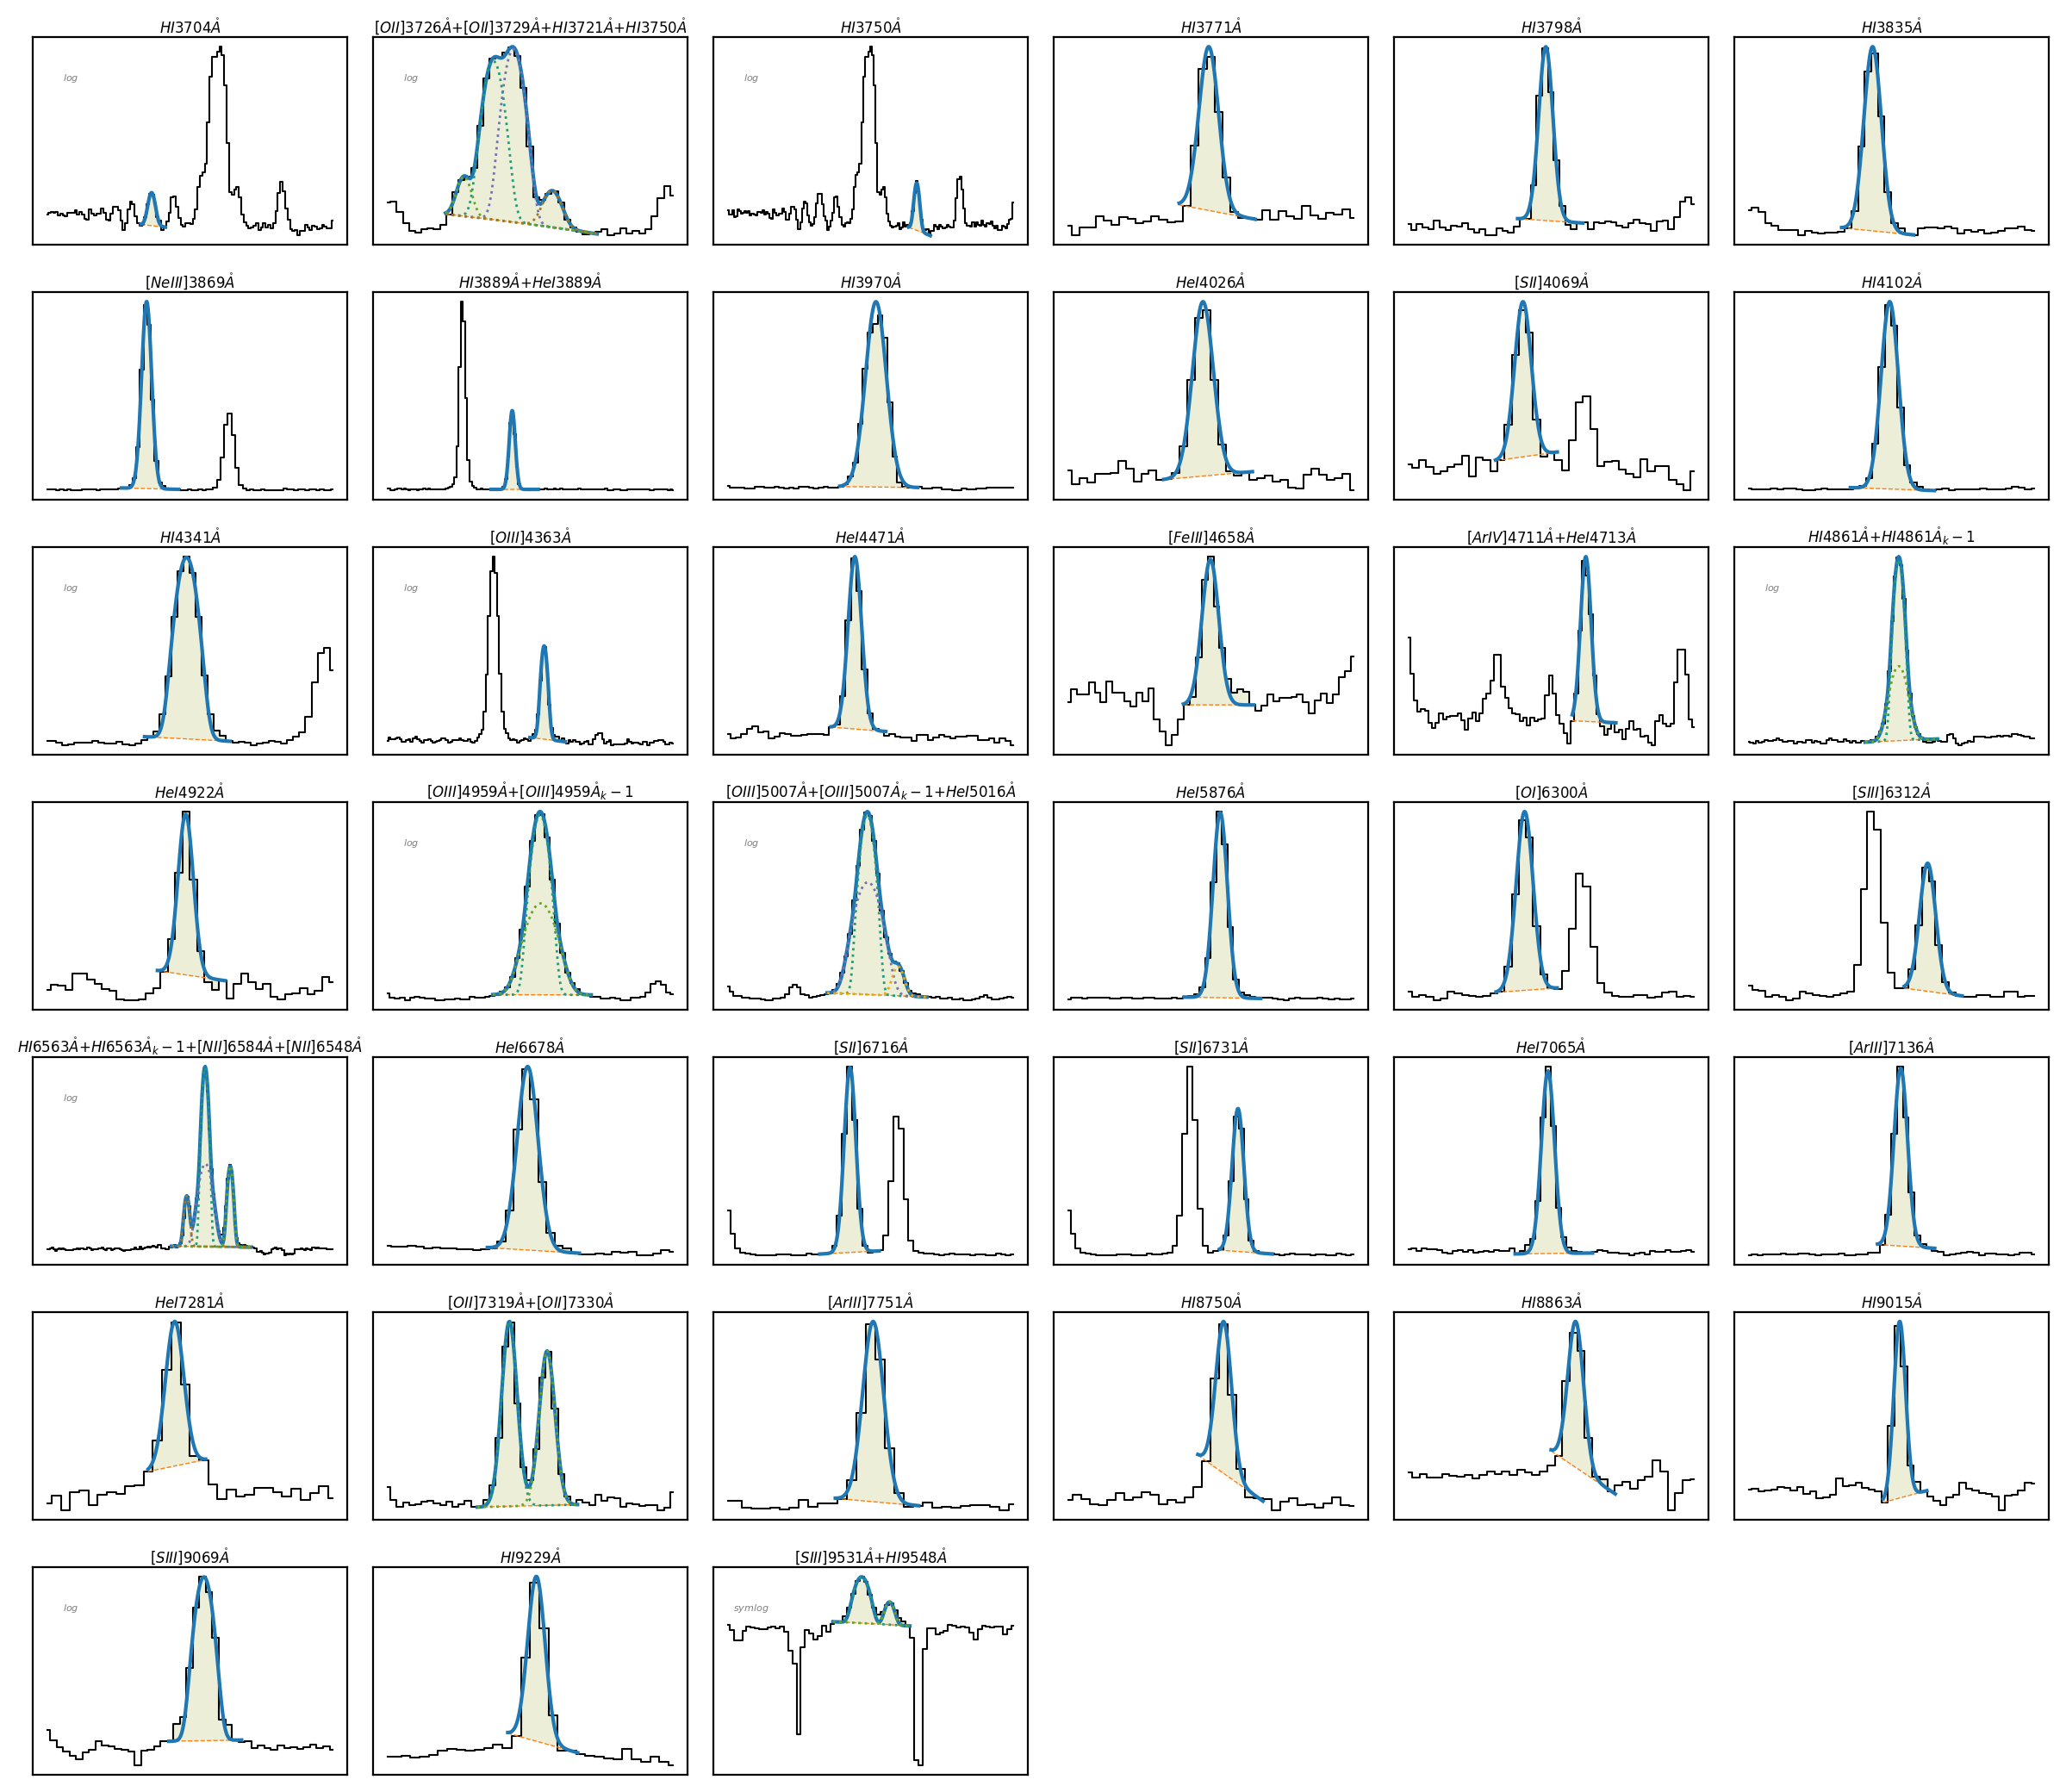

In [4]:
# Check the individual spaxel fitting configuration
spaxel = shoc579.get_spectrum(38, 35)
spaxel.load_frame(output_lines_log_file, page='38-35_LINELOG')
spaxel.plot.grid()

## Spatial parameter maps

The [$\tt{lime.save\_parameter\_maps}$](../3_explanations/0_measurements.rst) can extract the parameter maps as multi-page *.fits* file:

In [5]:
# Export the line measurements as spatial maps:
param_list = ['intg_flux', 'intg_flux_err', 'profile_flux', 'profile_flux_err', 'v_r', 'v_r_err']
lines_list = ['H1_4861A', 'H1_6563A', 'O3_4363A', 'O3_4959A', 'O3_5007A', 'S3_6312A', 'S3_9069A', 'S3_9531A']
lime.save_parameter_maps(output_lines_log_file, '../0_resources/', param_list, lines_list,
                         mask_file=spatial_mask_file, output_file_prefix='SHOC579_', wcs=shoc579.wcs)

[==========] 100% of spaxels from file "../0_resources/SHOC579_log.fits" read (227 total)


<div class="alert alert-success">

**Please remember:** The inputs and outputs of the ``lime.save_parameter_maps`` can only be *.fits* files and the ``mask_file`` argument is necessary to make sure only the spaxels with scientific data are considered 
    
</div>

This function produces different outputs depending on its arguments:

* The ``param_list`` argument establishes which parameters from the input ``output_lines_log_file`` will be exported into a *.fits* file. There will be *.fits* file per item on the ``param_list``. These files will be stored on the ``output_folder``  using ``output_files_prefix`` and the item name. The item name must follow the parameter notation of the [logs measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html).
* The ``line_list`` arguments establishes, which line measurements are exported to the output parameter *.fits* files. Each file will have one extension per line.
* The user can specify a binary mask with the ``mask_file`` argument. By default default it will use all the masks extensions on the input *.fits* unless the user specifies certain masks with the ``mask_list`` argument.

At this point we plot some flux ratio diagnostics from theses maps. Let's define them:

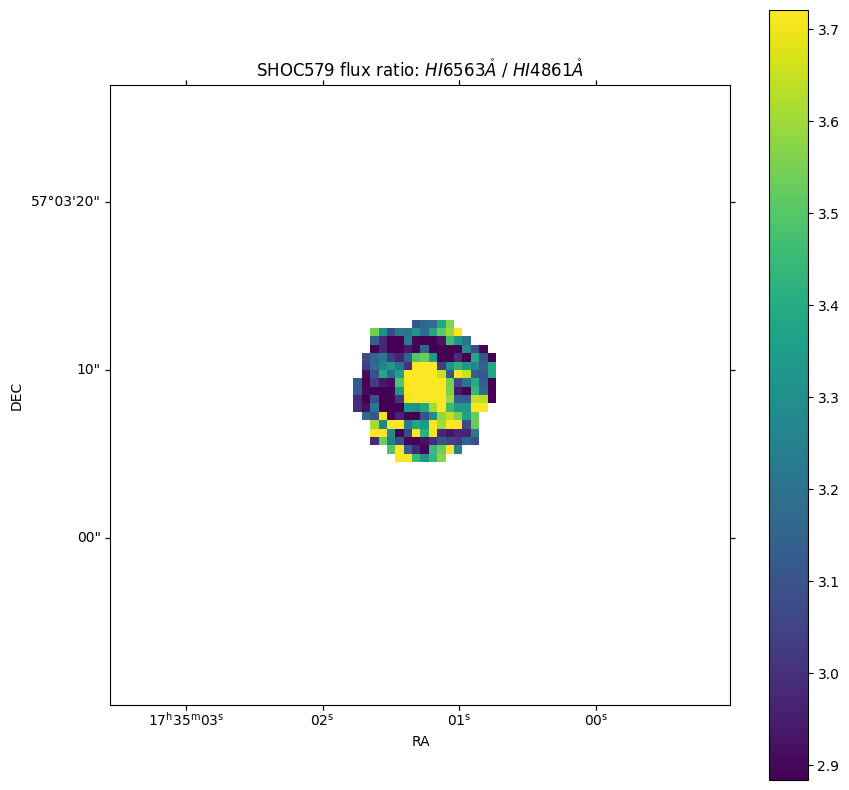

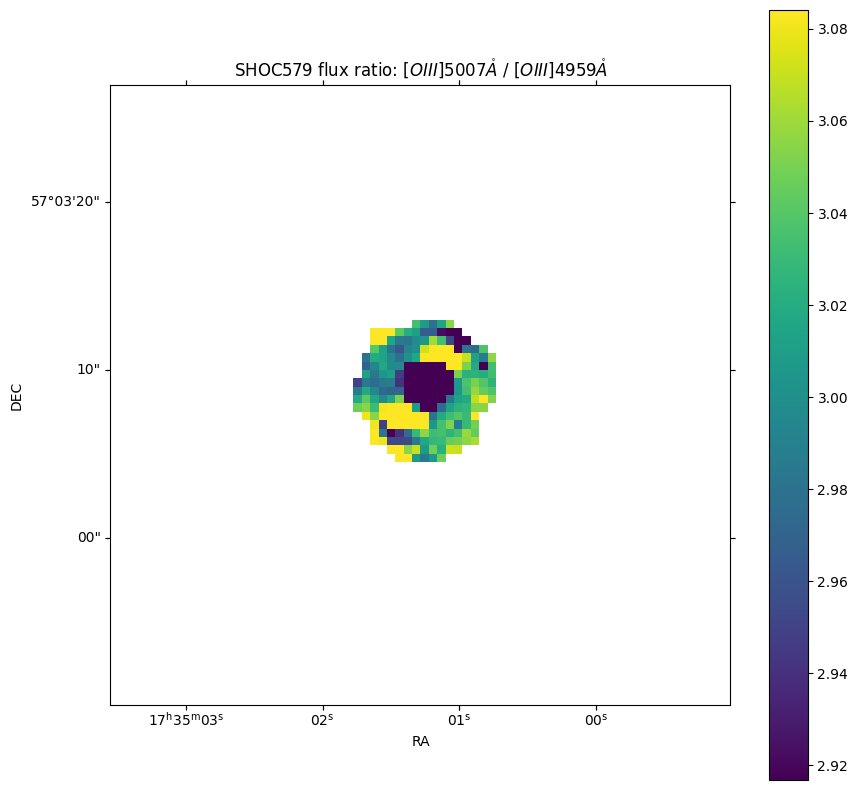

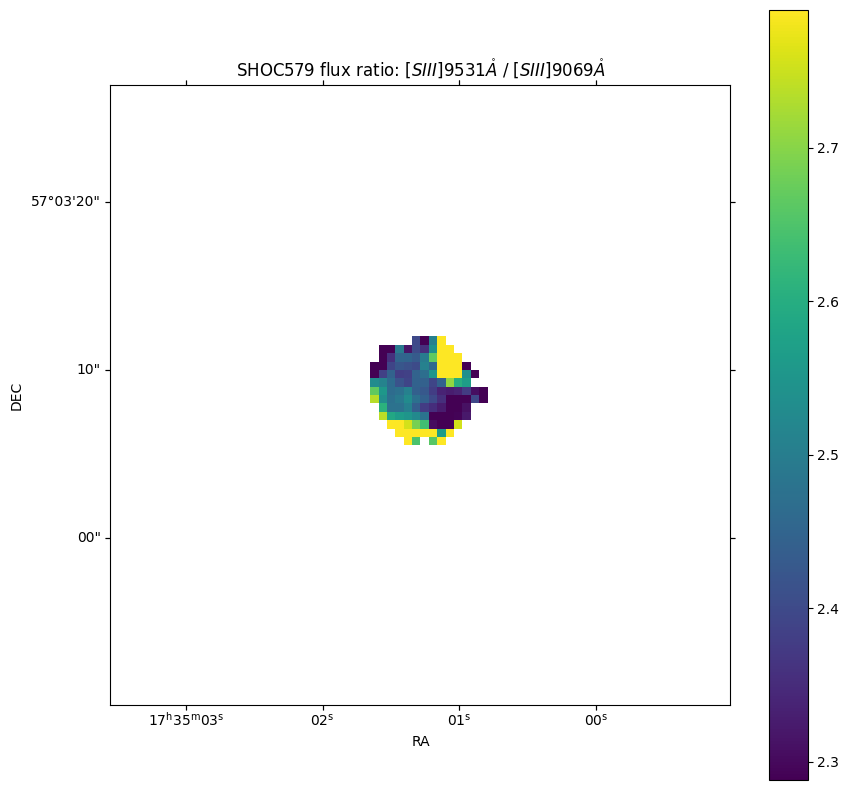

In [6]:
# State line ratios for the plots
lines_ratio = {'H1': ['H1_6563A', 'H1_4861A'],
               'O3': ['O3_5007A', 'O3_4959A'],
               'S3': ['S3_9531A', 'S3_9069A']}

# State the parameter map file
fits_file = f'../0_resources/SHOC579_profile_flux.fits'

# Loop through the line ratios
for ion, lines in lines_ratio.items():

    # Recover the parameter measurements
    latex_array = lime.label_decomposition(lines, params_list=['latex_label'])[0]
    ratio_map = fits.getdata(fits_file, lines[0]) / fits.getdata(fits_file, lines[1])
    Halpha = fits.getdata(fits_file, lines[0])
    Hbeta = fits.getdata(fits_file, lines[1])

    # Get the astronomical coordinates from one of the headers of the lines log
    hdr = fits.getheader(fits_file, lines[0])
    wcs_maps = WCS(hdr)

    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection=wcs_maps, slices=('x', 'y'))
    im = ax.imshow(ratio_map, vmin=np.nanpercentile(ratio_map, 16), vmax=np.nanpercentile(ratio_map, 84))
    cbar = fig.colorbar(im, ax=ax)
    ax.update({'title': f'SHOC579 flux ratio: {latex_array[0]} / {latex_array[1]}', 'xlabel': r'RA', 'ylabel': r'DEC'})
    plt.show()

## Take aways
* The [$\tt{lime.Cube.check.cube}$](../3_explanations/0_measurements.rst) function can be used to checked the fitted line profiles by using the ``lines_file`` argument. Similarly you can extract individual spectra using  $\tt{lime.Cube.get\_spectrum}$ the function and loading the spaxel measurements using $\tt{lime.Spectrum.load\_frame}$.
* The [$\tt{lime.save\_parameter\_maps}$](../3_explanations/0_measurements.rst) function can generate spatial parameters from the requested ``params`` as a multi-page fits file.
* You can read the function documentation in the [API](https://lime-stable.readthedocs.io/en/latest/reference/API.html).